# Django based movie recommender system
Author: Xiaolan
## Algorithm- Item_based CF filering & SVD decomposition RecSys

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split 
from prettytable import PrettyTable

In [2]:
"""
using ml rating dataset (which has ideal number of ratings for this project)
"""
df_rating = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/ml-latest-small/ml-latest-small/ratings.csv').iloc[:,:3]
df_rating.columns = ['userid', 'movieid', 'ratings']
# get top 30 popular movies 
popular_movies = list(df_rating.movieid.value_counts()[:30].index)
df_rating = df_rating[df_rating['movieid'].isin(popular_movies)]
vc = df_rating['userid'].value_counts()
# get user that rated at least 5 movies
user_index = list(vc[vc>=5].index)
# subset ratings to 1000
df_rating = df_rating[df_rating.userid.isin(user_index)][:1000].reset_index(drop=True)
df_rating

,userid,movieid,ratings
0,1,1,4.0
1,1,47,5.0
2,1,50,5.0
3,1,110,4.0
4,1,260,5.0
...,...,...,...
995,93,480,5.0
996,93,527,5.0
997,93,588,4.0
998,93,593,5.0


In [3]:
# """
# using system's rating dataset in this project
# """
# df_rating = pd.read_csv('movie_rating.csv',index_col=0)
# df_rating.columns = ['id','userid', 'movieid', 'ratings']
# df_rating

In [4]:
df_rating.movieid.unique()

array([   1,   47,   50,  110,  260,  296,  356,  457,  480,  527,  592,
        593,  608,  780, 1196, 1198, 1210, 2028, 2571, 2858, 2959,  588,
       2762,  150,  318,  589, 4993, 5952, 7153,  858], dtype=int64)

In [5]:
df_rating.userid.value_counts()

68    30
91    28
28    27
63    27
18    27
      ..
49     6
88     6
22     6
73     5
31     5
Name: userid, Length: 73, dtype: int64

## Using Item_based collabrative filtering

In [6]:
userRatings = df_rating.pivot_table(index=['userid'],columns=['movieid'],values='ratings')
userRatings

movieid,1,47,50,110,150,260,296,318,356,457,...,1198,1210,2028,2571,2762,2858,2959,4993,5952,7153
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,NaN,5.0,3.0,NaN,4.0,5.0,...,5.0,5.0,4.0,5.0,NaN,5.0,5.0,NaN,NaN,NaN
4,NaN,2.0,NaN,NaN,NaN,5.0,1.0,NaN,NaN,5.0,...,3.0,NaN,NaN,1.0,4.0,5.0,2.0,NaN,NaN,NaN
5,4.0,NaN,4.0,4.0,3.0,NaN,5.0,3.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,1.0,5.0,4.0,NaN,2.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,4.5,NaN,4.5,5.0,NaN,NaN,5.0,NaN,...,NaN,4.0,NaN,NaN,4.5,4.0,NaN,4.5,4.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,NaN,NaN,4.0,NaN,5.0,4.0,4.0,5.0,5.0,4.0,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,4.0,NaN,NaN,NaN,NaN,4.5,NaN,4.5,4.0,4.0,...,NaN,4.0,3.5,4.5,4.0,4.0,3.5,4.0,4.0,4.0
88,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0


In [7]:
corrMatrix = userRatings.corr(method='pearson').fillna(0)
corrMatrix

movieid,1,47,50,110,150,260,296,318,356,457,...,1198,1210,2028,2571,2762,2858,2959,4993,5952,7153
movieid,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.391293,0.432920,-0.073169,0.156017,-0.083767,0.102075,0.331680,0.345445,0.179306,...,0.081750,-0.357411,0.247083,0.288909,0.325288,0.183581,0.386545,0.234330,0.442570,0.322144
47,0.391293,1.000000,0.275847,0.560650,0.448575,-0.220399,0.330103,0.181554,0.381997,0.097608,...,0.293831,-0.024414,0.455179,0.759673,0.349537,-0.005984,0.636325,0.356862,0.440551,0.666103
50,0.432920,0.275847,1.000000,0.135125,0.126436,0.518696,0.485898,0.158265,0.008693,0.117580,...,0.331169,0.476600,0.500576,0.604196,0.643252,0.574014,0.464458,0.326132,0.342512,0.170561
110,-0.073169,0.560650,0.135125,1.000000,0.397157,-0.085668,0.254587,0.203312,0.418972,0.362718,...,-0.242463,0.212552,0.302006,0.735886,0.730603,-0.077190,0.407099,0.537072,0.863970,0.547076
150,0.156017,0.448575,0.126436,0.397157,1.000000,0.418008,0.228678,0.292320,0.515007,-0.032677,...,-0.767423,-0.141248,0.417902,0.347524,0.570899,-0.436542,0.268194,0.769800,0.537086,0.037878
260,-0.083767,-0.220399,0.518696,-0.085668,0.418008,1.000000,-0.064300,0.063582,0.161517,0.738293,...,0.461285,0.772344,0.030625,0.068574,0.002247,0.151463,-0.275702,0.149278,0.098864,0.077296
296,0.102075,0.330103,0.485898,0.254587,0.228678,-0.064300,1.000000,0.194737,0.099728,-0.425602,...,0.073215,-0.052985,-0.058137,0.605060,0.562958,0.263057,0.730494,0.156013,0.010808,0.086048
318,0.331680,0.181554,0.158265,0.203312,0.292320,0.063582,0.194737,1.000000,0.431414,-0.005941,...,0.024735,0.129219,-0.115231,0.156957,0.368792,-0.214848,0.218434,-0.049378,0.217293,0.069852
356,0.345445,0.381997,0.008693,0.418972,0.515007,0.161517,0.099728,0.431414,1.000000,0.123277,...,-0.267460,0.308780,0.623564,0.440886,0.115764,0.061080,-0.045603,-0.060914,0.344321,0.080272


#### Predict ratings for items
The method I use to predict the rating for specific user and item is as below, where K is the neighborhood of most similar items rated by active user a, and w(i,j) is the similarity between items i and j.

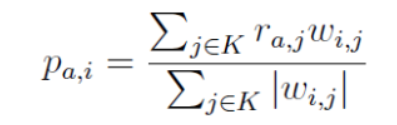

In [8]:
def evaluate():
    df_predict = pd.DataFrame()
    for user_i in userRatings.index:
        myRatings = userRatings.loc[user_i].dropna()

        for movie_i in list(myRatings.index):
            # retrieve similar movies for movie i
            similar_movies = corrMatrix[movie_i]
            # substract to similar score between movie i and rated movies
            similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
            # calculate predict rating
            # adding 0.01 to avoid 0 similar score in low number of ratings system
            predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
            df_predict = df_predict.append([[user_i, movie_i,predict_ratings]])

    df_predict.columns = ['user_id','movie_id','predict_rating']
    df_predict.reset_index(drop=True,inplace=True)
    
    return df_predict

# evaluate rms
cf_rms = mean_squared_error(df_rating['ratings'], evaluate()['predict_rating'], squared=False)
cf_rms

1.1704367467528805

In [9]:
 evaluate().head(10)

,user_id,movie_id,predict_rating
0,1,1,3.265740
1,1,47,3.742907
2,1,50,4.207115
3,1,110,3.163463
4,1,260,3.455309
5,1,296,2.516996
6,1,356,3.447386
7,1,457,3.511252
8,1,480,3.517242
9,1,527,4.217337


In [10]:
def recommend_movie(user_id, hm):
    myRatings = userRatings.loc[user_id].dropna()
    similar_candidates = pd.DataFrame()
    for i in list(corrMatrix.index):
        # retrieve similar movies for movie i
        similar_movies = corrMatrix[i]
        # substract to similar score between movie i and rated movies
        similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
        # calculate predict rating
        predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
        similar_candidates = similar_candidates.append([predict_ratings])
    similar_candidates.index = corrMatrix.index
    # substract recommend movies that  have rated
    similar_candidates = similar_candidates[~similar_candidates.index.isin(myRatings.index)]
    similar_candidates.columns = ['predict_rating']
    similar_candidates.sort_values(by='predict_rating',inplace=True,ascending=False)    
    return similar_candidates[:hm]
# recommend movies for user_id 1
rec_movie = recommend_movie(user_id=1,hm=10)
rec_movie

,predict_rating
movieid,
4993,4.399453
7153,4.356152
2762,4.211232
5952,3.788420
318,3.595328
858,3.510217
588,3.143781
589,1.676416
150,1.277681


In [11]:
# movies that user 1 has rated
myRatings = userRatings.loc[1].dropna()
myRatings

movieid
1       4.0
47      5.0
50      5.0
110     4.0
260     5.0
296     3.0
356     4.0
457     5.0
480     4.0
527     5.0
592     4.0
593     4.0
608     5.0
780     3.0
1196    5.0
1198    5.0
1210    5.0
2028    4.0
2571    5.0
2858    5.0
2959    5.0
Name: 1, dtype: float64

In [12]:
print('recommend movie id are', list(rec_movie.index))

recommend movie id are [4993, 7153, 2762, 5952, 318, 858, 588, 589, 150]


## Using SVD model

In [13]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_rating[['userid','movieid','ratings']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25, random_state=30)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
svd_rms = accuracy.rmse(predictions)
print(svd_rms)

RMSE: 0.8417
0.841722832318184


In [14]:
def pred_user_rating(ui):
    if ui in df_rating.userid.unique():
        ui_list = df_rating[df_rating.userid == ui].movieid.tolist()
        d = df_rating.movieid.unique()
        d = [v for v in d if not v in ui_list] 
        predictedL = []
        for j in d:     
            predicted = algorithm.predict(ui, j)
            predictedL.append((j, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movieid', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movieid', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [15]:
df_rating.userid.unique()

array([ 1,  4,  5,  6,  7,  8, 10, 11, 14, 15, 16, 17, 18, 19, 21, 22, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43,
       45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 86, 88, 91, 93], dtype=int64)

In [16]:
# recommend movies for user_id 1
rec_movie = pred_user_rating(1)
rec_movie

,ratings
movieid,
858,4.662533
7153,4.550945
318,4.522858
2762,4.351888
588,4.248398
589,4.209262
5952,4.197712
150,4.148314
4993,4.049626


In [17]:
# movies that user 1 has rated
df_rating[df_rating.userid == 1]

,userid,movieid,ratings
0,1,1,4.0
1,1,47,5.0
2,1,50,5.0
3,1,110,4.0
4,1,260,5.0
5,1,296,3.0
6,1,356,4.0
7,1,457,5.0
8,1,480,4.0
9,1,527,5.0


## Merge them together

In [18]:
class item_basedCF:
    def __init__(self):
        self.userRatings = df_rating.pivot_table(index=['userid'],columns=['movieid'],values='ratings')
        self.corrMatrix =  self.userRatings.corr(method='pearson').fillna(0)
        self.cf_rms = mean_squared_error(df_rating['ratings'],  self.evaluate()['predict_rating'], squared=False)
    def evaluate(self):
        df_predict = pd.DataFrame()
        for user_i in  self.userRatings.index:
            myRatings =  self.userRatings.loc[user_i].dropna()

            for movie_i in list(myRatings.index):
                # retrieve similar movies for movie i
                similar_movies =  self.corrMatrix[movie_i]
                # substract to similar score between movie i and rated movies
                similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
                # calculate predict rating
                # adding 0.01 to avoid 0 similar score in low number of ratings system
                predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
                df_predict = df_predict.append([[user_i, movie_i,predict_ratings]])

        df_predict.columns = ['user_id','movie_id','predict_rating']
        df_predict.reset_index(drop=True,inplace=True)

        return df_predict

    def recommend_movie(self, user_id):
        myRatings =  self.userRatings.loc[user_id].dropna()
        similar_candidates = pd.DataFrame()
        for i in list( self.corrMatrix.index):
            # retrieve similar movies for movie i
            similar_movies =  self.corrMatrix[i]
            # substract to similar score between movie i and rated movies
            similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
            # calculate predict rating
            predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
            similar_candidates = similar_candidates.append([predict_ratings])
        similar_candidates.index =  self.corrMatrix.index
        # substract recommend movies that  have rated
        similar_candidates = similar_candidates[~similar_candidates.index.isin(myRatings.index)]
        similar_candidates.columns = ['predict_rating']
        similar_candidates.sort_values(by='predict_rating',inplace=True,ascending=False)    
        return similar_candidates[:10]

In [19]:
class svd_based:
    def __init__(self):
        # instantiate a reader and read in our rating data
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(df_rating[['userid','movieid','ratings']], reader)

        # train SVD on 75% of known rates
        trainset, testset = train_test_split(data, test_size=.25, random_state=30)
        self.algorithm = SVD()
        self.algorithm.fit(trainset)
        predictions =  self.algorithm.test(testset)

        # check the accuracy using Root Mean Square Error
        self.svd_rms = accuracy.rmse(predictions)
    def pred_user_rating(self, ui):
        if ui in df_rating.userid.unique():
            ui_list = df_rating[df_rating.userid == ui].movieid.tolist()
            d = df_rating.movieid.unique()
            d = [v for v in d if not v in ui_list] 
            predictedL = []
            for j in d:     
                predicted =  self.algorithm.predict(ui, j)
                predictedL.append((j, predicted[3])) 
            pdf = pd.DataFrame(predictedL, columns = ['movieid', 'ratings'])
            pdf.sort_values('ratings', ascending=False, inplace=True)  
            pdf.set_index('movieid', inplace=True)    
            return pdf.head(10)        
        else:
            print("User Id does not exist in the list!")
            return None

In [20]:
itembased_object = item_basedCF()
svdbased_object = svd_based()
# choose either one system by lower rmse 
if itembased_object.cf_rms > svdbased_object.svd_rms:
    movie_rec = svdbased_object.pred_user_rating(1)  # predict for user one
    print('svd based: ',svdbased_object.svd_rms)
else:
    movie_rec = itembased_object.recommend_movie(1)
    print('item based: ',itembased_object.cf_rms)
movie_rec

RMSE: 0.8244
svd based:  0.8243650498175716


,ratings
movieid,
318,4.866555
858,4.678286
7153,4.554914
5952,4.316446
2762,4.303782
4993,4.233504
589,4.200690
588,4.197087
150,4.085132


## MRR vs MAP vs NDCG Rank-Aware Evaluation Metrics 
Reference: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832

FeedBack evaluation using test data.

From the above recommended movies for user 5 and 4, we assumed they like some of them, and create the feeback test dataset as follows.

In [21]:
# create list to store the ranking evaluation result
list_item_ranking = []
list_svd_ranking = []
ranking_method = ['MRR', 'MAP','NDCG']

#### In item based

In [22]:
itembased_object.recommend_movie(5).index

Int64Index([7153, 4993, 593, 2762, 2028, 47, 5952, 2959, 2571, 260], dtype='int64', name='movieid')

In [23]:
itembased_object.recommend_movie(4).index

Int64Index([4993, 50, 592, 2028, 7153, 1210, 356, 1, 318, 858], dtype='int64', name='movieid')

We assume user5 likes movies 2028, 593, 7153; user4 likes movies 50 and 858.

In [24]:
NaN = np.nan
user5_like = [2028, 593, 7153]
user4_like = [50, 858]

In [25]:
df_item_user5 = pd.DataFrame(NaN, index=itembased_object.recommend_movie(5).index, columns=['like'])
df_item_user5['like'] = df_item_user5[df_item_user5['like'].index.isin(user5_like)].fillna(1)
df_item_user5.reset_index(inplace = True)
df_item_user5.index += 1
# adding rating score for NDCG method calculation
rating_data = [4, 0, 4, 0, 3, 0, 2, 0, 0, 1 ]
df_item_user5['ratings'] = rating_data
df_item_user5

,movieid,like,ratings
1,7153,1.0,4
2,4993,NaN,0
3,593,1.0,4
4,2762,NaN,0
5,2028,1.0,3
6,47,NaN,0
7,5952,NaN,2
8,2959,NaN,0
9,2571,NaN,0
10,260,NaN,1


In [26]:
df_item_user4 = pd.DataFrame(NaN, index=itembased_object.recommend_movie(4).index, columns=['like'])
df_item_user4['like'] = df_item_user4[df_item_user4['like'].index.isin(user4_like)].fillna(1)
df_item_user4.reset_index(inplace = True)
df_item_user4.index += 1
# adding rating score for NDCG method calculation
rating_data = [0, 4, 0, 2, 0, 2, 0, 1, 0, 5 ]
df_item_user4['ratings'] = rating_data
df_item_user4

,movieid,like,ratings
1,4993,NaN,0
2,50,1.0,4
3,592,NaN,0
4,2028,NaN,2
5,7153,NaN,0
6,1210,NaN,2
7,356,NaN,0
8,1,NaN,1
9,318,NaN,0
10,858,1.0,5


#### MRR: Mean Reciprocal Rank
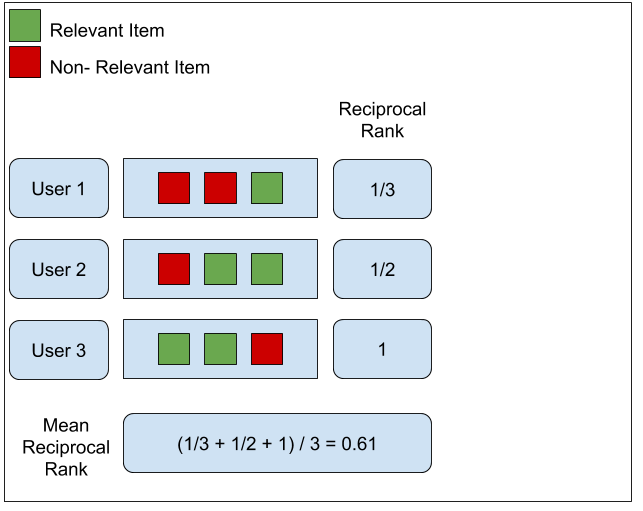


In [27]:
list_item_ranking.append(np.round((1/1 + 1/2)/2, 2))
list_item_ranking[-1]

0.75

#### MAP: Average Precision and Mean Average Precision
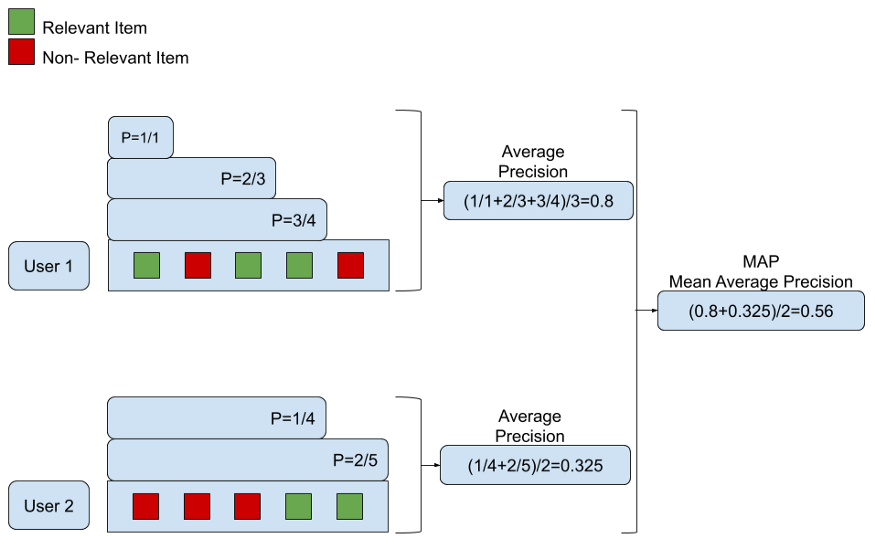

In [28]:
list_item_ranking.append(np.round((((1/1+2/3+3/5)/3) + ((1/2+2/10)/2))/2,2))
list_item_ranking[-1]

0.55

#### NDCG: Normalized Discounted Cumulative Gain
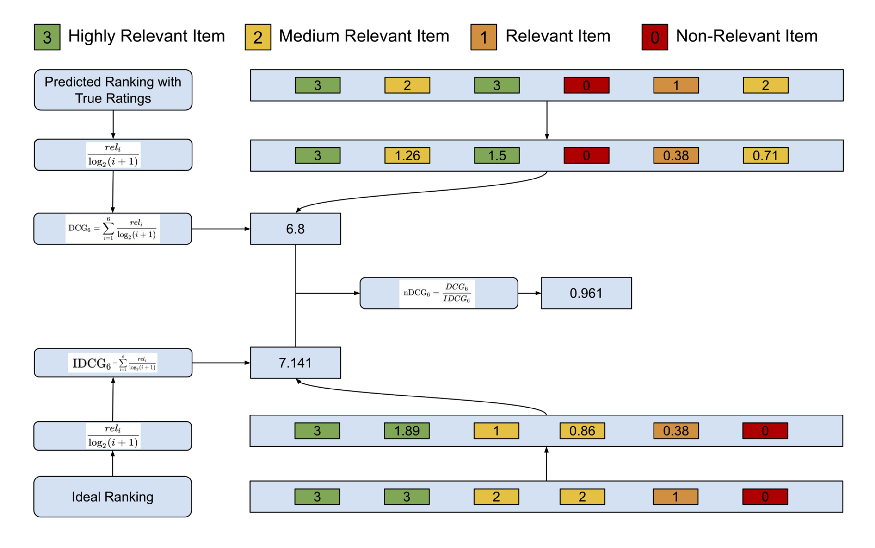

In [29]:
DCG = 4/np.log2(2)+4/np.log2(4)+3/np.log2(6)+2/np.log2(8)+1/np.log2(11)
IDCG = 4/np.log2(2)+4/np.log2(3)+3/np.log2(4)+2/np.log2(5)+1/np.log2(6)
NDCG_user5 = DCG/IDCG

DCG = 4/np.log2(3)+2/np.log2(5)+2/np.log2(7)+1/np.log2(9)+5/np.log2(11)
IDCG = 5/np.log2(2)+4/np.log2(3)+2/np.log2(4)+2/np.log2(5)+1/np.log2(6)
NDCG_user4 = DCG/IDCG


list_item_ranking.append(np.round((NDCG_user5+NDCG_user4)/2,2))
list_item_ranking[-1]

0.74

#### In svd based

In [30]:
df_svd_user5 = pd.DataFrame(NaN, index=svdbased_object.pred_user_rating(5).index, columns=['like'])
df_svd_user5['like'] = df_svd_user5[df_svd_user5['like'].index.isin(user5_like)].fillna(1)
df_svd_user5.reset_index(inplace = True)
df_svd_user5.index += 1
# adding rating score for NDCG method calculation
rating_data = [4, 0, 0, 4, 1, 3, 0, 0, 0, 2 ]
df_svd_user5['ratings'] = rating_data
df_svd_user5

,movieid,like,ratings
1,858,NaN,4
2,1198,NaN,0
3,1210,NaN,0
4,260,NaN,4
5,593,1.0,1
6,1196,NaN,3
7,2028,1.0,0
8,7153,1.0,0
9,5952,NaN,0
10,356,NaN,2


In [31]:
df_svd_user4 = pd.DataFrame(NaN, index=svdbased_object.pred_user_rating(4).index, columns=['like'])
df_svd_user4['like'] = df_svd_user4[df_svd_user4['like'].index.isin(user4_like)].fillna(1)
df_svd_user4.reset_index(inplace = True)
df_svd_user4.index += 1
# adding rating score for NDCG method calculation
rating_data = [2, 4, 0, 2, 5, 0, 0, 1, 0, 0 ]
df_svd_user4['ratings'] = rating_data
df_svd_user4

,movieid,like,ratings
1,318,NaN,2
2,2028,NaN,4
3,858,1.0,0
4,7153,NaN,2
5,1210,NaN,5
6,4993,NaN,0
7,527,NaN,0
8,589,NaN,1
9,110,NaN,0
10,356,NaN,0


In [32]:
# MRR
list_svd_ranking.append(np.round((1/4+1/7)/2,2))
list_svd_ranking[-1]

0.2

In [33]:
# MAP
list_svd_ranking.append(np.round(((1/4+2/7+3/8)/3 + (1/7+2/10)/2)/2, 2))
list_svd_ranking[-1]

0.24

In [34]:
# NDCG
DCG = 4/np.log2(2)+4/np.log2(5)+1/np.log2(6)+3/np.log2(7)+2/np.log2(11)
IDCG = 4/np.log2(2)+4/np.log2(3)+3/np.log2(4)+2/np.log2(5)+1/np.log2(6)
NDCG_user5 = DCG/IDCG

DCG = 2/np.log2(2)+4/np.log2(3)+2/np.log2(5)+5/np.log2(6)+1/np.log2(9)
IDCG = 5/np.log2(2)+4/np.log2(3)+2/np.log2(4)+2/np.log2(5)+1/np.log2(6)
NDCG_user4 = DCG/IDCG


list_svd_ranking.append(np.round((NDCG_user5+NDCG_user4)/2,2))
list_svd_ranking[-1]

0.81

#### Ranking Evaluation Result

In [35]:
t = PrettyTable(['ranking_method','item', 'svd'])
for i in range(len(list_item_ranking)):
    t.add_row([ranking_method[i], list_item_ranking[i], list_svd_ranking[i]])
print(t)

+----------------+------+------+
| ranking_method | item | svd  |
+----------------+------+------+
|      MRR       | 0.75 | 0.2  |
|      MAP       | 0.55 | 0.24 |
|      NDCG      | 0.74 | 0.81 |
+----------------+------+------+


MRR and NDCG performs highest ranking evaluation than MAP in item based recommender system.

Besides, NDCG performs a relatively higer ranking evaluation than MRR and MAP in svd based recommender system.

Thus, NDCG is the best method to evaluate the ranking.